# CORDEX relief from PyGMT

In [1]:
import cf_xarray as cfxr
import cordex as cx
import pygmt
import xesmf as xe

In [2]:
def get_domain(domain):
    ds = cx.cordex_domain(domain, add_vertices=True)
    ds = ds.assign(
        lon_b=cfxr.bounds_to_vertices(ds.lon_vertices, "vertices"),
        lat_b=cfxr.bounds_to_vertices(ds.lat_vertices, "vertices"),
    ).drop(("lon_vertices", "lat_vertices"))
    ds.lon.attrs['bounds'] = 'lon_bounds'
    ds.lat.attrs['bounds'] = 'lat_bounds'
    return ds

eur11 = get_domain("EUR-11")
eur11

/Users/lars/python/packages/py-cordex/cordex/core/domain.py:645: UserWarning: Order of vertices has changed since v0.3.2 to CF Conventions, see https://github.com/euro-cordex/py-cordex/issues/34
  warn(


<xarray.Dataset>
Dimensions:                     (rlon: 424, rlat: 412, rlat_vertices: 413,
                                 rlon_vertices: 425)
Coordinates:
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.05 18.16
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.73 21.84
    lon                         (rlat, rlon) float64 -10.06 -9.964 ... 64.96
    lat                         (rlat, rlon) float64 21.99 22.03 ... 66.75 66.69
Dimensions without coordinates: rlat_vertices, rlon_vertices
Data variables:
    rotated_latitude_longitude  int32 0
    lon_b                       (rlat_vertices, rlon_vertices) float64 -10.09...
    lat_b                       (rlat_vertices, rlon_vertices) float64 21.92 ...
Attributes:
    CORDEX_domain:  EUR-11

In [3]:
def create_relief(domain, resolution):
    
    ds = get_domain(domain)
    #ds = cx.cordex_domain(domain, add_vertices=True)
    #ds["lon_vertices"] = ds.lon_vertices.roll(vertices=-1)
    #ds["lat_vertices"] = ds.lat_vertices.roll(vertices=-1)
    region = [
        ds.lon.min().data,
        ds.lon.max().data,
        ds.lat.min().data,
        ds.lat.max().data,
    ]
    grid = pygmt.datasets.load_earth_relief(resolution=resolution, region=region)
    regridder = xe.Regridder(grid.to_dataset(), ds, method="conservative_normed")
    ds["topo"] = regridder(grid)
    return ds

In [4]:
def plot(da, pole, vmin=None, vmax=None, borders=True):
    """plot a domain using the right projection with cartopy"""
    %matplotlib inline
    import cartopy.crs as ccrs
    import cartopy.feature as cf
    import matplotlib.pyplot as plt

    plt.figure(figsize=(20, 10))
    projection = ccrs.PlateCarree()
    transform = ccrs.RotatedPole(pole_latitude=pole[1], pole_longitude=pole[0])
    # ax = plt.axes(projection=projection)
    ax = plt.axes(projection=transform)
    # ax.set_extent([ds_sub.rlon.min(), ds_sub.rlon.max(), ds_sub.rlat.min(), ds_sub.rlat.max()], crs=transform)
    ax.gridlines(
        draw_labels=True,
        linewidth=0.5,
        color="gray",
        xlocs=range(-180, 180, 10),
        ylocs=range(-90, 90, 5),
    )
    da.plot(
        ax=ax,
        cmap="terrain",
        transform=transform,
        vmin=vmin,
        vmax=vmax,
        x="rlon",
        y="rlat",
    )
    ax.coastlines(resolution="50m", color="black", linewidth=1)
    if borders is True:
        ax.add_feature(cf.BORDERS)
    # Show the grid lines as dark grey lines

In [5]:
def test_domain(domain, resolution="01d"):
    ds = create_relief(domain, resolution)
    pole = (
        ds.rotated_latitude_longitude.grid_north_pole_longitude,
        ds.rotated_latitude_longitude.grid_north_pole_latitude,
    )
    plot(ds.topo, pole, vmin=-1000, vmax=3000)
    return ds

/Users/lars/python/packages/py-cordex/cordex/core/domain.py:645: UserWarning: Order of vertices has changed since v0.3.2 to CF Conventions, see https://github.com/euro-cordex/py-cordex/issues/34
  warn(
pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -44.5938638919 to -44.6666666667
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from 64.9643766672 to 65
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 21.9878287568 to 21.8333333333
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 72.5849

CPU times: user 11 s, sys: 733 ms, total: 11.7 s
Wall time: 12.6 s


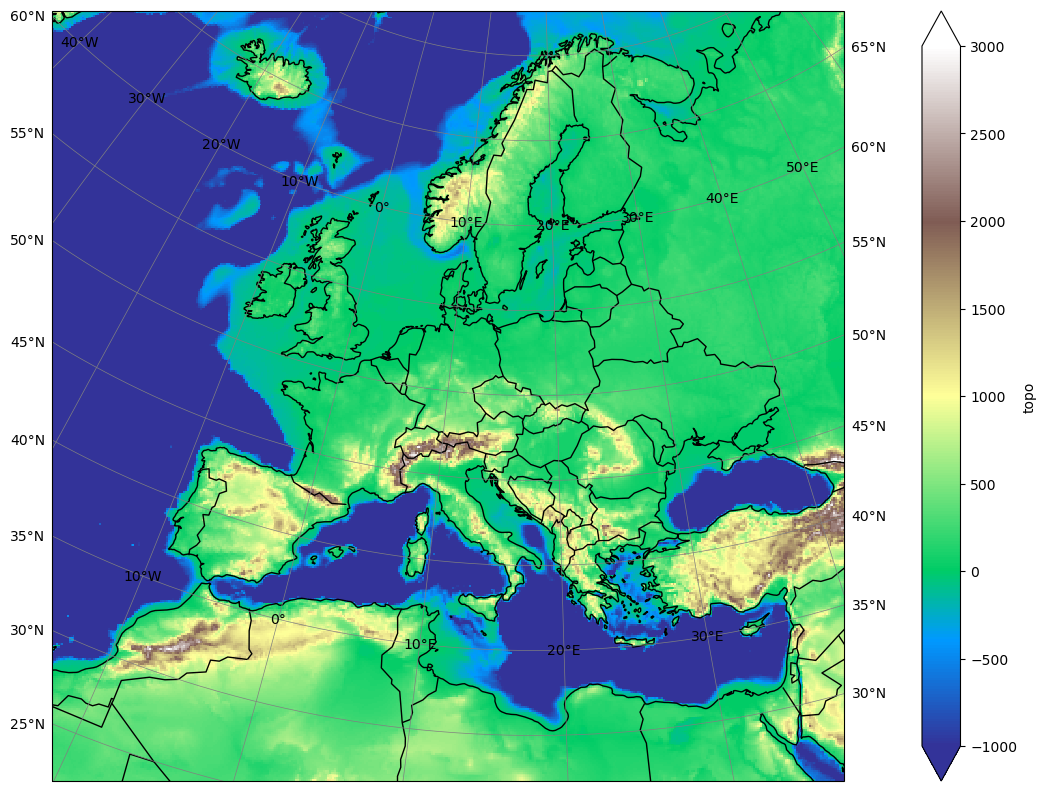

In [6]:
%time ds = test_domain("EUR-11", resolution="10m")

/Users/lars/python/packages/py-cordex/cordex/core/domain.py:645: UserWarning: Order of vertices has changed since v0.3.2 to CF Conventions, see https://github.com/euro-cordex/py-cordex/issues/34
  warn(
pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -3.33129210749 to -4
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from 17.4263582362 to 18
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 38.2663424608 to 38
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 51.9990401075 to 52
/Users/lar

CPU times: user 4.25 s, sys: 411 ms, total: 4.66 s
Wall time: 5.03 s


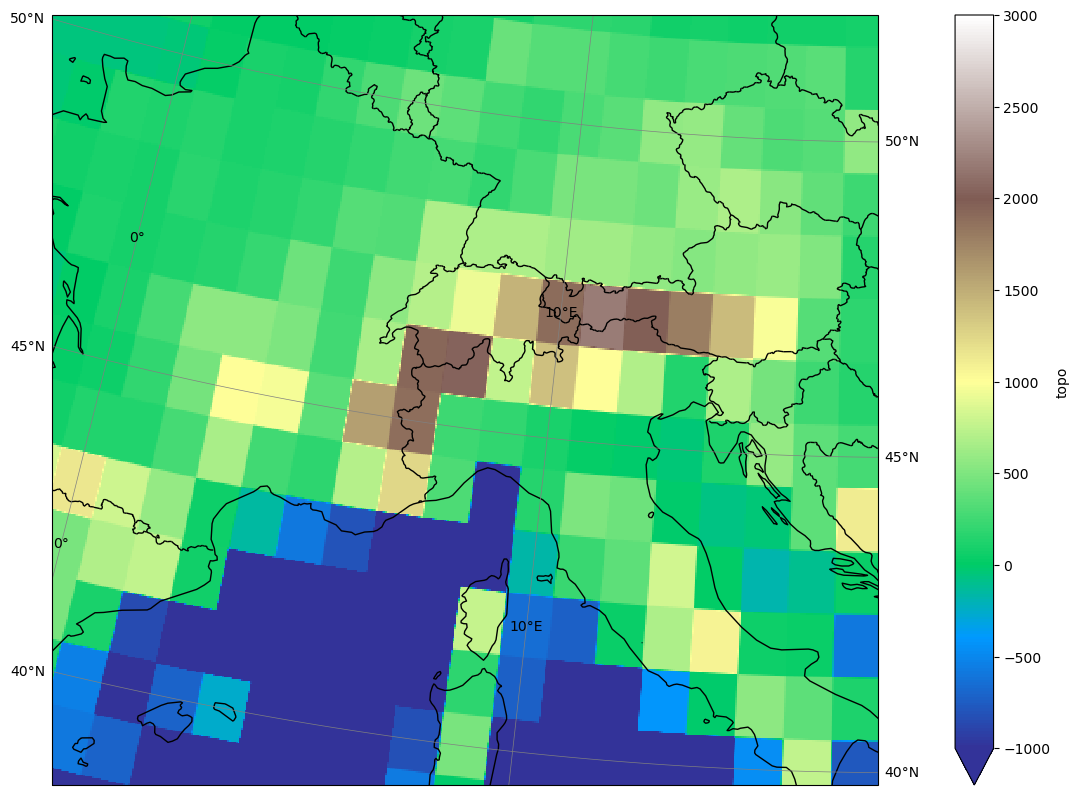

In [7]:
%time ds = test_domain("GAR-0275", resolution="01d")

/Users/lars/python/packages/py-cordex/cordex/core/domain.py:645: UserWarning: Order of vertices has changed since v0.3.2 to CF Conventions, see https://github.com/euro-cordex/py-cordex/issues/34
  warn(
pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -3.33129210749 to -3.5
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from 17.4263582362 to 17.5
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 38.2663424608 to 38.25
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 51.9990401075 to 52
/Us

CPU times: user 5.11 s, sys: 494 ms, total: 5.6 s
Wall time: 6.07 s


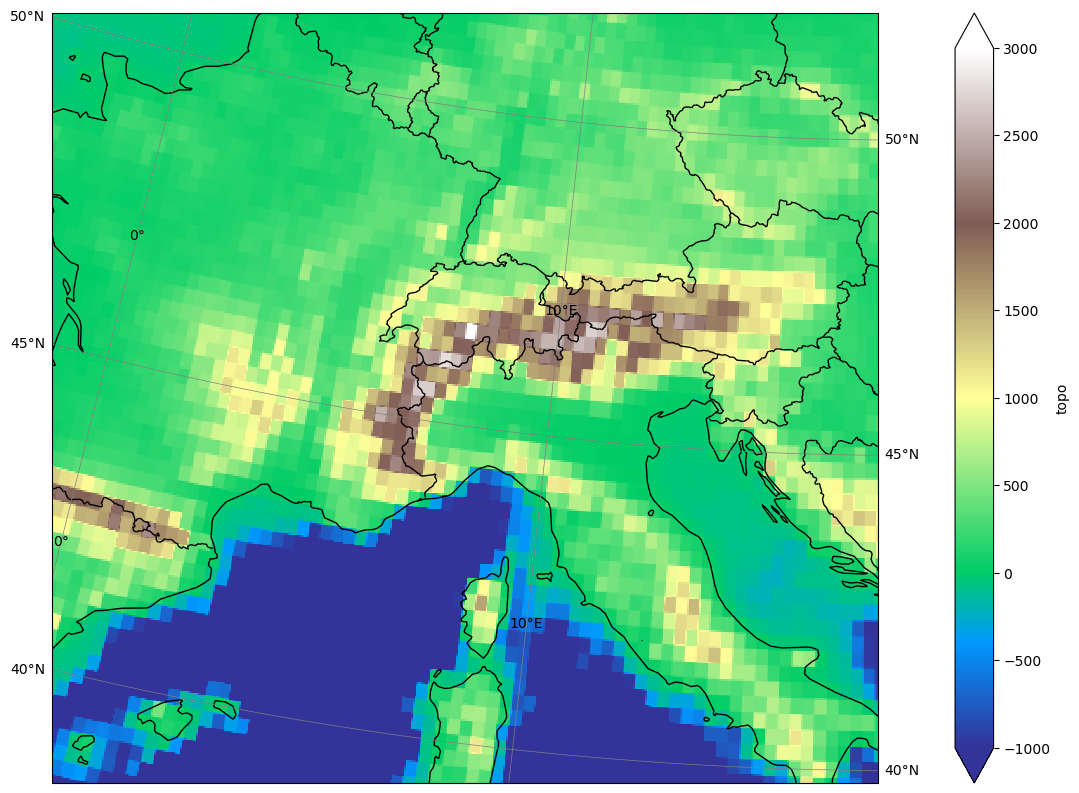

In [8]:
%time ds = test_domain("GAR-0275", resolution="15m")

/Users/lars/python/packages/py-cordex/cordex/core/domain.py:645: UserWarning: Order of vertices has changed since v0.3.2 to CF Conventions, see https://github.com/euro-cordex/py-cordex/issues/34
  warn(
pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -3.33129210749 to -3.33333333333
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from 17.4263582362 to 17.4333333333
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 38.2663424608 to 38.2333333333
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset f

CPU times: user 14.6 s, sys: 1.17 s, total: 15.8 s
Wall time: 18.6 s


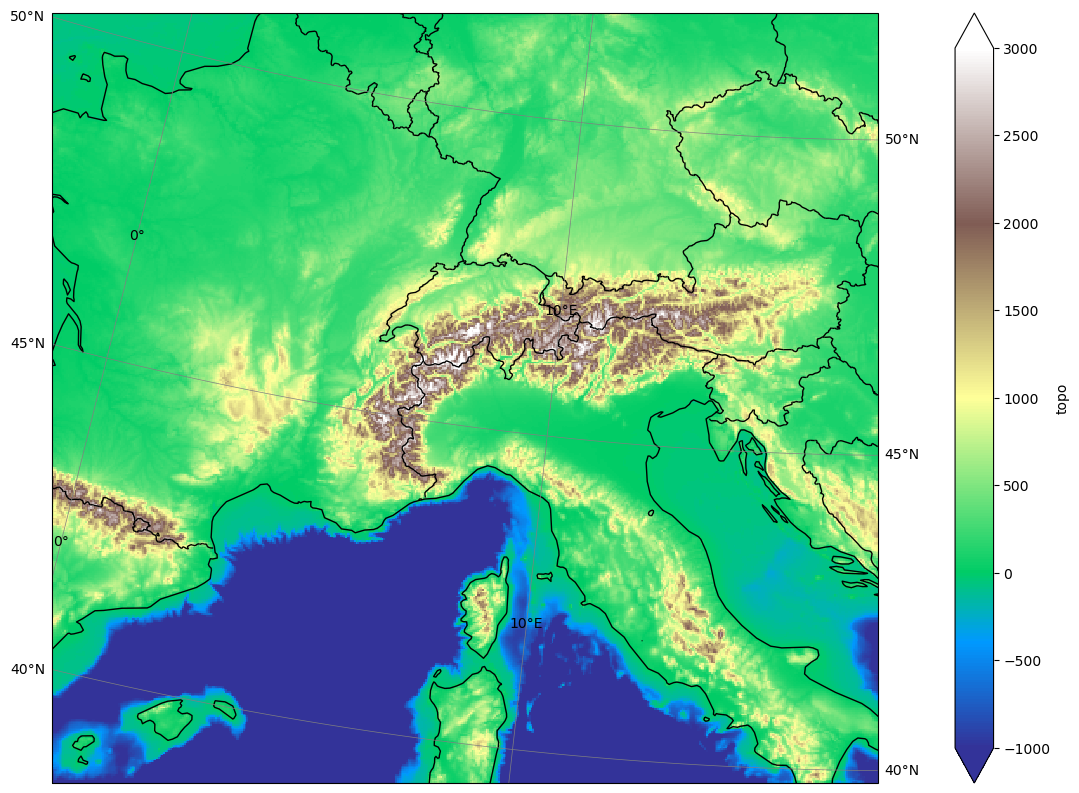

In [9]:
%time ds = test_domain("GAR-0275", resolution="02m")

/Users/lars/python/packages/py-cordex/cordex/core/domain.py:645: UserWarning: Order of vertices has changed since v0.3.2 to CF Conventions, see https://github.com/euro-cordex/py-cordex/issues/34
  warn(
pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -3.33129210749 to -3.33333333333
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from 17.4263582362 to 17.4333333333
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 38.2663424608 to 38.25
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 51.9

CPU times: user 34.7 s, sys: 2.58 s, total: 37.3 s
Wall time: 40.4 s


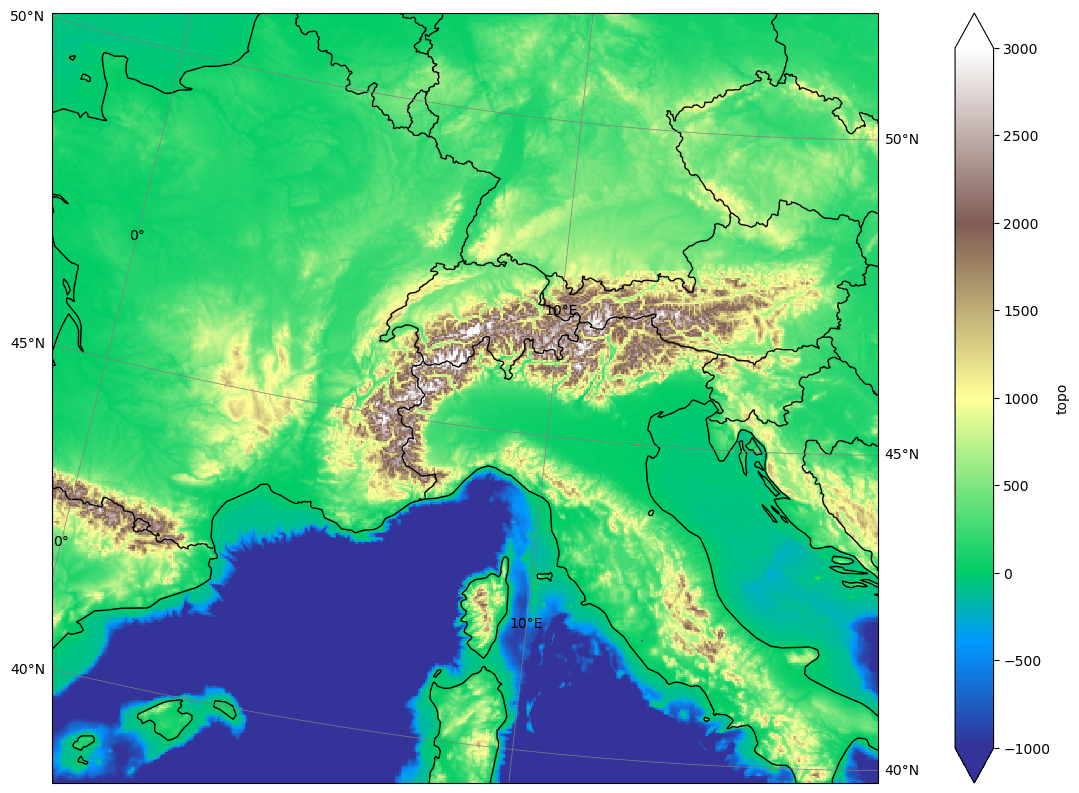

In [10]:
%time ds = test_domain("GAR-0275", resolution="01m")